In [1]:
pwd()

'C:\\Users\\rp2815'

In [1]:
#Import libraries:
import pandas as pd
import numpy as np
from sklearn.ensemble import BaggingClassifier  #RF algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Performing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

train = pd.read_csv('F:\second_term\ADS\proj3\Train.csv')
test = pd.read_csv('F:\second_term\ADS\proj3\Test.csv')
target = 'y' #this is y
IDcol = 'ID'

D:\Anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Anaconda\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#Functions for building the model
def modelfit(alg, dtrain, dtest, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['y'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    dtest_predictions = alg.predict(dtest[predictors])
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['y'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy(train): %.4g" % metrics.accuracy_score(dtrain['y'].values, dtrain_predictions))
    print ("Accuracy(test) : %.4g" % metrics.accuracy_score(dtest['y'].values, dtest_predictions))
    #print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['y'], dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        

In [ ]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
#initial estimates:
#min_samples_split = 200 : This should be ~0.5-1% of total values.
#min_samples_leaf = 50 : Can be selected based on intuition. This is just used for preventing overfitting and again a small value because of imbalanced classes.
#max_depth = 1 : for decision stump
#max_features = ‘sqrt’ : Its a general thumb-rule to start with square root.
#subsample = 0.8 : This is a commonly-used start value
#n_estimators=100 : Can be selected based on intuition.
#max_features= "sqrt": typical sqrt to 30-40% of total features

#This is the untuned baseline, the parameters are not necesarily the best.
rf0 = BaggingClassifier(base_estimator=None, n_estimators=60, max_samples=1.0, 
                        max_features=1.0, bootstrap=True, bootstrap_features=False,
                        oob_score=False, warm_start=False, n_jobs=1, random_state=10, verbose=0)
modelfit(rf0, train,test, predictors)#Train: 1 Test:73%

In [106]:
#Parameter Tuning for baseline model
####################################################################################
#All about the Tree
#(1) Fix learning rate and number of estimators for tuning tree-based parameters
#initial estimates:

#min_samples_split = 200 : This should be ~0.5-1% of total values.
#min_samples_leaf = 50 : Can be selected based on intuition. This is just used for preventing overfitting and again a small value because of imbalanced classes.
#max_depth = 1 : for decision stump
#max_features = ‘sqrt’ : Its a general thumb-rule to start with square root.
#subsample = 0.8 : This is a commonly-used start value

#a.find the best number of stumps we train
predictors = [x for x in train.columns if x not in [target, IDcol]]
#param_test1 = {'n_estimators':range(20,81,10)}
param_test1 = {'n_estimators':[50,60,70,80,90,100,110,120,130]}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(max_features='sqrt',
                                                               random_state=10,
                                                               loss = 'exponential',
                                                               learning_rate=0.1, 
                                                               min_samples_split = 200,
                                                               min_samples_leaf = 50,
                                                               max_depth = 1,
                                                               subsample=0.8), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
#->n_estimators = 120

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_


([mean: 0.74316, std: 0.02459, params: {'n_estimators': 50},
  mean: 0.74861, std: 0.02377, params: {'n_estimators': 60},
  mean: 0.75183, std: 0.01973, params: {'n_estimators': 70},
  mean: 0.75522, std: 0.02039, params: {'n_estimators': 80},
  mean: 0.76279, std: 0.01835, params: {'n_estimators': 90},
  mean: 0.76603, std: 0.01856, params: {'n_estimators': 100},
  mean: 0.77021, std: 0.01706, params: {'n_estimators': 110},
  mean: 0.77082, std: 0.01814, params: {'n_estimators': 120},
  mean: 0.77078, std: 0.01752, params: {'n_estimators': 130}],
 {'n_estimators': 120},
 0.7708236727426705)

In [104]:
#(2)Tuning tree-specific parameters
#param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
#gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), 
#param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
#gsearch2.fit(train[predictors],train[target])
#gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_
#->max_depth of 9 as optimum

#param_test3 = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10)}
#gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9,max_features='sqrt', subsample=0.8, random_state=10), 
#param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
#gsearch3.fit(train[predictors],train[target])
#gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_
#->1200 for min_samples_split and 60 for min_samples_leaf

#find the best number of features to consider in each split
param_test4 = {'max_features':[20,30,40,55,57,59,61,63,65,67,69]}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(random_state=10,
                                                               n_estimators=120,
                                                               loss = 'exponential',
                                                               learning_rate=0.1, 
                                                               min_samples_split = 200,
                                                               min_samples_leaf = 50,
                                                               max_depth = 1,
                                                               subsample=0.8),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_
#max_features = 67

#Compared the tuned base model with the base model
#modelfit(gsearch3.best_estimator_, train, predictors)

([mean: 0.72264, std: 0.02193, params: {'max_features': 20},
  mean: 0.72852, std: 0.02656, params: {'max_features': 30},
  mean: 0.74219, std: 0.02740, params: {'max_features': 40},
  mean: 0.75835, std: 0.02375, params: {'max_features': 55},
  mean: 0.76114, std: 0.02551, params: {'max_features': 57},
  mean: 0.76243, std: 0.02387, params: {'max_features': 59},
  mean: 0.76366, std: 0.02356, params: {'max_features': 61},
  mean: 0.76981, std: 0.02420, params: {'max_features': 63},
  mean: 0.76994, std: 0.01958, params: {'max_features': 65},
  mean: 0.77100, std: 0.02071, params: {'max_features': 67},
  mean: 0.76551, std: 0.01594, params: {'max_features': 69}],
 {'max_features': 67},
 0.77100011975685234)

In [105]:
#Parameter Tuning
####################################################################################
#(1)Tuning subsample
param_test5 = {'subsample':[0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,1]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(random_state=10,
                                                               n_estimators=120,
                                                               loss = 'exponential',
                                                               learning_rate=0.1, 
                                                               min_samples_split = 200,
                                                               min_samples_leaf = 50,
                                                               max_depth = 1,
                                                               max_features = 67),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_
#->0.8 as the optimum value for subsample

([mean: 0.74972, std: 0.01983, params: {'subsample': 0.4},
  mean: 0.75163, std: 0.02120, params: {'subsample': 0.5},
  mean: 0.75728, std: 0.02943, params: {'subsample': 0.6},
  mean: 0.76410, std: 0.02861, params: {'subsample': 0.7},
  mean: 0.75883, std: 0.01956, params: {'subsample': 0.75},
  mean: 0.76551, std: 0.01594, params: {'subsample': 0.8},
  mean: 0.75583, std: 0.01920, params: {'subsample': 0.85},
  mean: 0.76089, std: 0.02429, params: {'subsample': 0.9}],
 {'subsample': 0.8},
 0.76551216413846945)

In [ ]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_1 = GradientBoostingClassifier(random_state=10,
                                         subsample=0.8,
                                         n_estimators=120,
                                         loss = 'exponential',
                                         learning_rate=0.1,
                                         min_samples_split = 200,
                                         min_samples_leaf = 50,
                                         max_depth = 1,
                                         max_features = 67)
modelfit(gbm_tuned_1, train, test,predictors)


Model Report
Accuracy : 0.7788
AUC Score (Train): 0.868661
CV Score : Mean - 0.7734367 | Std - 0.02692101 | Min - 0.7336303 | Max - 0.8152055


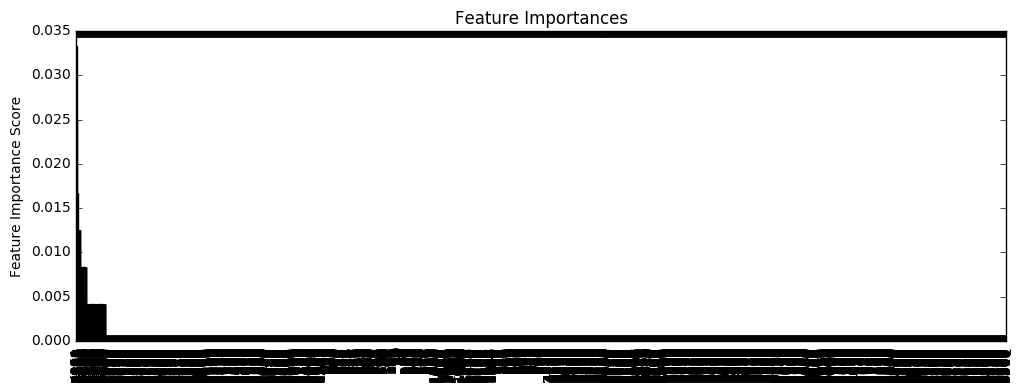

In [109]:
#########################################################################
#(2)making models with lower learning rate
#Lets decrease the learning rate to half, i.e. 0.05 with twice (120) the number of trees.

predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_2 = GradientBoostingClassifier(random_state=10,
                                         subsample=0.8,
                                         n_estimators=240,
                                         loss = 'exponential',
                                         learning_rate=0.05,
                                         min_samples_split = 200,
                                         min_samples_leaf = 50,
                                         max_depth = 1,
                                         max_features = 67)
modelfit(gbm_tuned_2, train, test,predictors)


Model Report
Accuracy : 0.86
AUC Score (Train): 0.954813
CV Score : Mean - 0.8091383 | Std - 0.03073468 | Min - 0.7694236 | Max - 0.8427318


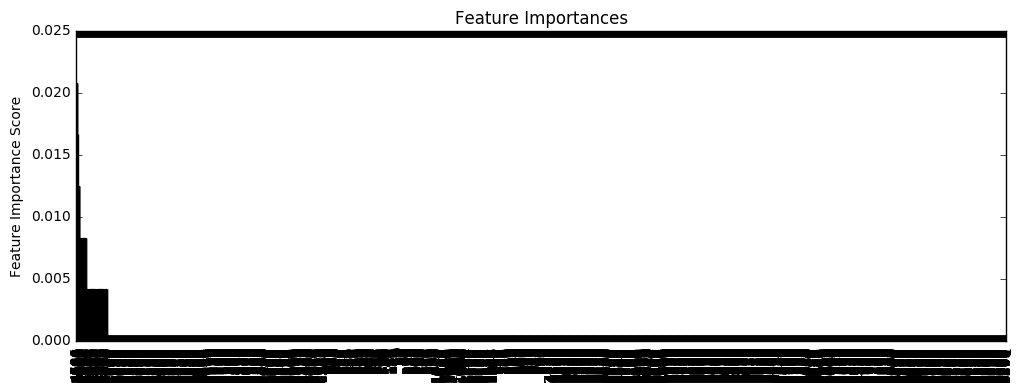


Model Report
Accuracy : 0.7937
AUC Score (Train): 0.879441
CV Score : Mean - 0.7815947 | Std - 0.02701695 | Min - 0.7431239 | Max - 0.8256759


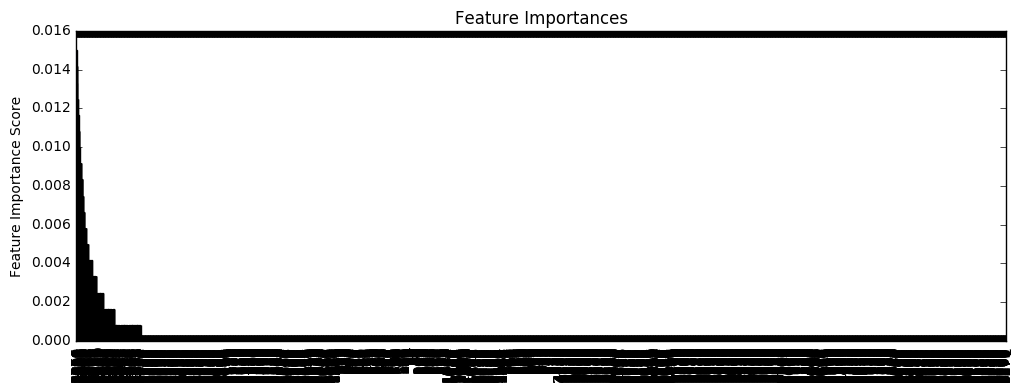

In [111]:
#Now lets reduce to one-tenth of the original value, i.e. 0.01 for 600 trees.

predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_3 = GradientBoostingClassifier(random_state=10,
                                         subsample=0.8,
                                         n_estimators=1200,
                                         loss = 'exponential',
                                         learning_rate=0.01,
                                         min_samples_split = 200,
                                         min_samples_leaf = 50,
                                         max_depth = 1,
                                         max_features = 67)
modelfit(gbm_tuned_3, train,test, predictors)


Model Report
Accuracy : 0.8825
AUC Score (Train): 0.962161
CV Score : Mean - 0.8040103 | Std - 0.03600455 | Min - 0.7468672 | Max - 0.843985


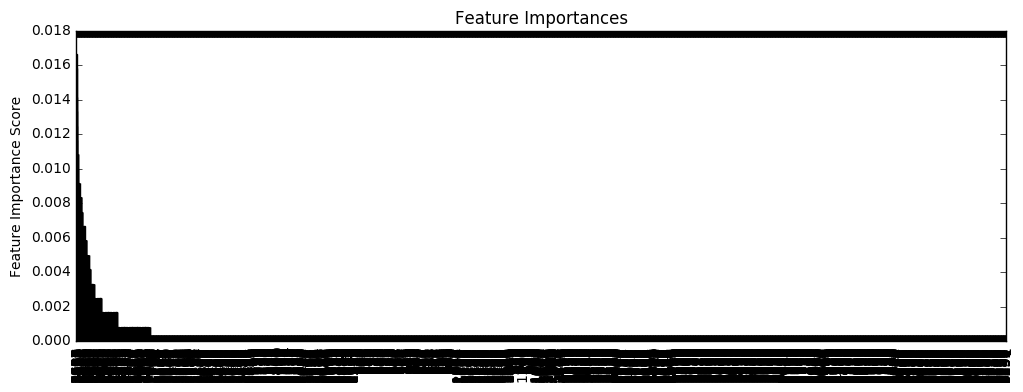


Model Report
Accuracy : 0.79
AUC Score (Train): 0.880359
CV Score : Mean - 0.7812565 | Std - 0.02364049 | Min - 0.7463276 | Max - 0.817745


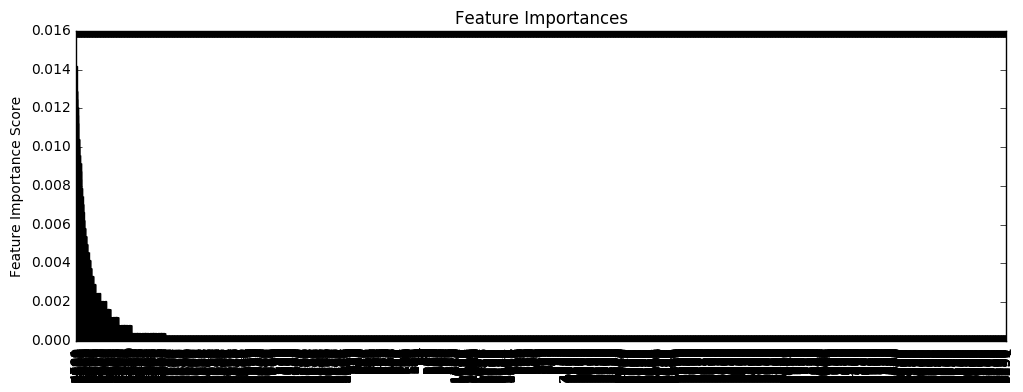

In [119]:
#Lets decrease to one-twentieth of the original value, i.e. 0.005 for 1200 trees.
#Another hack that can be used here is the ‘warm_start’ parameter of GBM. You can use it to 
#increase the number of estimators in small steps and test different values without having to run from starting always
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_4 = GradientBoostingClassifier(random_state=10,
                                         subsample=0.8,
                                         n_estimators=2400,
                                         loss = 'exponential',
                                         learning_rate=0.005,
                                         min_samples_split = 200,
                                         min_samples_leaf = 50,
                                         max_depth = 1,
                                         max_features = 67)

modelfit(gbm_tuned_4, train,test, predictors)


Model Report
Accuracy : 0.8775
AUC Score (Train): 0.964242
CV Score : Mean - 0.8041859 | Std - 0.03886907 | Min - 0.7437343 | Max - 0.8446115


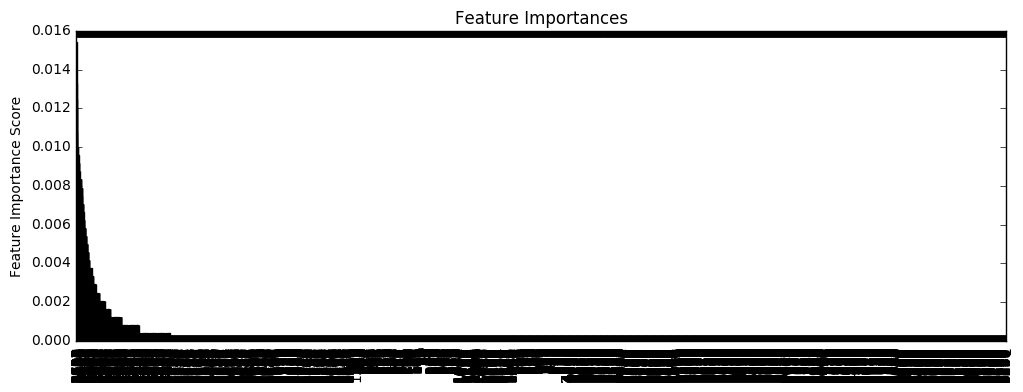

In [ ]:
#tuned parameter:
#random_state=10,subsample=0.8,n_estimators=1200,loss = 'exponential',learning_rate=0.01,
#min_samples_split = 200,min_samples_leaf = 50,max_depth = 1,max_features = 67